# Genetic Algorithm for OPTIMIZATION

The equation y=ax2+bx+c, when graphed, creates a parabola. 

I will use a GA to find the combination of values for \[a, b, c] that results in the flattest parabola.

In [4]:
import os
import random
import psutil

import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [5]:
# FITNESS FUNCTION

def fitness_function(params):
    a,b,c = params
    
    if a<=0:
        return -float('inf')

    #Define the point in plane
    vertex_x = -b / (2 * a) #x value at vertex
    vertex_y = a * (vertex_x ** 2) + b * vertex_x + c #y value at vertex
    
    y_left = a * (-1) ** 2 + b * (-1) + c #y-coordinate at x = -1
    y_right = a * (1) ** 2 + b * (1) + c #y-coordinate at x = 1
    
    curviness = abs(y_left - vertex_y) + abs(y_right - vertex_y)
    return -curviness  # most algorithms maximize the function, but we want min

In [6]:
# POPULATION CREATION

def create_initial_population(size, lower_bound, upper_bound):
    population=[]
    for _ in range(size): # by convention, to do something n times 
        #create random poins with the a,b,c parameteres
        individual = (random.uniform(lower_bound, upper_bound),
                      random.uniform(lower_bound, upper_bound),
                      random.uniform(lower_bound, upper_bound))
        population.append(individual)
    return population

In [7]:
# SELECTION FUNCTION - tournament approach

def selection_function(population, fitnesses, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

In [8]:
# CROSSOVE FUNCTION 

def crossover(parent_1, parent_2):
    alpha=random.random()
    
    child_1=tuple(alpha* p1 + (1-alpha)*p2 for p1,p2 in zip(parent_1,parent_2))
    child_2=tuple(alpha*p2 + (1-alpha)*p1 for p1,p2 in zip(parent_1,parent_2)) 
    
    return child_1,child_2

In [9]:
# MUTATION FUNCTION

def mutation(individual, mutation_rate, lower_bound, upper_bound):
    individual = list(individual)
    for i in range(len(individual)):
        if random.random() < mutation_rate: #[0.0,1.0) for random.random()  #why this form?
            mutation_amount = random.uniform(-1, 1)
            individual[i] += mutation_amount
            
            #Double check if individual is within bounds 
            individual[i] = max(min(individual[i], upper_bound), lower_bound)
    return tuple(individual)

In [10]:
# TERMINATION CONDITIONS - not necessarly needed

def termination_condition(fitnesses, target_fitness):
    return max(fitnesses) >= target_fitness

In [ ]:
# MAIN GENETIC ALGORITHM 

def genetic_algorithm(population_size, lower_bound, upper_bound, generations, mutation_rate):
    
    population = create_initial_population(population_size, lower_bound, upper_bound)
    
    best_performers = []
    all_populations = []

    # TABLE 
    table = PrettyTable()
    table.field_names = ["Generation", "a", "b", "c", "Fitness"]

    for generation in range(generations):
        fitnesses = [fitness_function(ind) for ind in population]

        # Store the best performer of the current generation
        best_individual = max(population, key=fitness_function)
        best_fitness = fitness_function(best_individual)
        best_performers.append((best_individual, best_fitness))
        all_populations.append(population[:])
        table.add_row([generation + 1, best_individual[0], best_individual[1], best_individual[2], best_fitness])

        population = selection_function(population, fitnesses)

        next_population = []
        for i in range(0, len(population) - 1, 2):
            parent1 = population[i]
            parent2 = population[i + 1]

            child1, child2 = crossover(parent1, parent2)

            next_population.append(mutation(child1, mutation_rate, lower_bound, upper_bound))
            next_population.append(mutation(child2, mutation_rate, lower_bound, upper_bound))
            
        if len(population) % 2 == 1:
            last_individual = population[-1]
            next_population.append(mutation(last_individual, mutation_rate, lower_bound, upper_bound))

        # Replace the old population with the new one, keep the best individual
        next_population[0] = best_individual
        population = next_population

    csv_str = table.get_csv_string()
    with open('quadratic/Generations.csv', 'w', newline='') as f:
        f.write(csv_str)
    print(table)

    # Plot for the population of the last generation
    final_population = all_populations[-1]
    final_fitnesses = [fitness_function(ind) for ind in final_population]

    fig_population, axs = plt.subplots(3, 1, figsize=(12, 18))

    axs[0].scatter(range(len(final_population)), [ind[0] for ind in final_population], color='blue', label='a values')
    axs[0].scatter([final_population.index(best_individual)], [best_individual[0]], color='cyan', s=100, label='Best Individual-a')
    axs[0].set_ylabel('a')
    axs[0].legend(loc='upper left')
    
    axs[1].scatter(range(len(final_population)), [ind[1] for ind in final_population], color='green', label='b values')
    axs[1].scatter([final_population.index(best_individual)], [best_individual[1]], color='magenta', s=100, label='Best Individual-b')
    axs[1].set_ylabel('b')
    axs[1].legend(loc='upper left')
    
    axs[2].scatter(range(len(final_population)), [ind[2] for ind in final_population], color='red', label='c values')
    axs[2].scatter([final_population.index(best_individual)], [best_individual[2]], color='yellow', s=100, label='Best Individual-c')
    axs[2].set_ylabel('c')
    axs[2].set_xlabel('Individual Index')
    axs[2].legend(loc='upper left')
    
    axs[0].set_title(f'Final Generation ({generations}) Population Solutions')

    # Plot the values of a, b, and c over generations
    generations_list = range(1, len(best_performers) + 1)
    a_values = [ind[0][0] for ind in best_performers]
    b_values = [ind[0][1] for ind in best_performers]
    c_values = [ind[0][2] for ind in best_performers]
    
    fig_params, ax = plt.subplots()    
    ax.plot(generations_list, a_values, label='a', color='blue')
    ax.plot(generations_list, b_values, label='b', color='green')
    ax.plot(generations_list, c_values, label='c', color='red')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Parameter Values')
    ax.set_title('Parameter Values Over Generations')
    ax.legend()

    # Plot the fitness values over generations
    best_fitness_values = [fit[1] for fit in best_performers]
    min_fitness_values = [min([fitness_function(ind) for ind in population]) for population in all_populations]
    max_fitness_values = [max([fitness_function(ind) for ind in population]) for population in all_populations]
    
    fig_fitness, ax = plt.subplots()
    ax.plot(generations_list, best_fitness_values, label='Best Fitness', color='black')
    ax.fill_between(generations_list, min_fitness_values, max_fitness_values, color='gray', alpha=0.5, label='Fitness Range')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title('Fitness Over Generations')
    ax.legend()

    # Plot the quadratic function for each generation
    fig_quadratic, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, generations))
    for i, (best_ind, best_fit) in enumerate(best_performers):
        color = colors[i]
        a, b, c = best_ind
        x_range = np.linspace(lower_bound, upper_bound, 400)
        y_values = a * (x_range ** 2) + b * x_range + c
        ax.plot(x_range, y_values, color=color)

    cax = fig_quadratic.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
    norm = plt.cm.colors.Normalize(vmin=0, vmax=generations)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    fig_quadratic.colorbar(sm, ax=ax, cax=cax, orientation='vertical', label='Generation')

    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_title('Quadratic Function Variants')

    figures = [fig_population, fig_params, fig_fitness, fig_quadratic]
    for fig in figures:
        plt.close(fig)

    return max(population, key=fitness_function), figures

In [12]:
%%time
process = psutil.Process(os.getpid())
mem_usage_mb_before = process.memory_info().rss / 1024 / 1024  # RAM Memory usage initially in bytes, transformed in MB
cpu_usage_percent_before = process.cpu_percent(interval=0.1)  # CPU percent (over 0.1seconds interval)

# PARAMETERS 
population_size = 100 # large population => find solution quicker, but more time
lower_bound = -50
upper_bound = 50 # range within the algorithm searches for a solution
generations = 20
mutation_rate = 1 # good for genetic diversity, will not get stuck to local optimum

best_solution, figs = genetic_algorithm(population_size, lower_bound, upper_bound, generations, mutation_rate)

mem_usage_mb_after = process.memory_info().rss / 1024 / 1024  # RAM Memory usage initially in bytes, transformed in MB
cpu_usage_percent_after = process.cpu_percent(interval=0.1)  # CPU percent (over 0.1seconds interval)
print(f"Memory usage before: {mem_usage_mb_before:.2f} MB, CPU usage before: {cpu_usage_percent_before:.2f}%")
print(f"Memory usage right after: {mem_usage_mb_after:.2f} MB, CPU usage right after: {cpu_usage_percent_after:.2f}%")

+------------+---------------------+----------------------+---------------------+----------------------+
| Generation |          a          |          b           |          c          |       Fitness        |
+------------+---------------------+----------------------+---------------------+----------------------+
|     1      |  6.519503835940064  |  3.328261654109319   |  -2.774295504422575 | -13.888560484254327  |
|     2      |  4.655897974882345  |  0.568354984584653   | -3.1416730961196424 |  -9.34648607723794   |
|     3      |  4.655897974882345  |  0.568354984584653   | -3.1416730961196424 |  -9.34648607723794   |
|     4      |  4.655897974882345  |  0.568354984584653   | -3.1416730961196424 |  -9.34648607723794   |
|     5      |  4.655897974882345  |  0.568354984584653   | -3.1416730961196424 |  -9.34648607723794   |
|     6      |  3.8079279764577816 |  2.207986248003068   |  -6.486988495476918 |  -8.255994540293164  |
|     7      |  3.076660127269331  |  2.446020207036615

# Plots

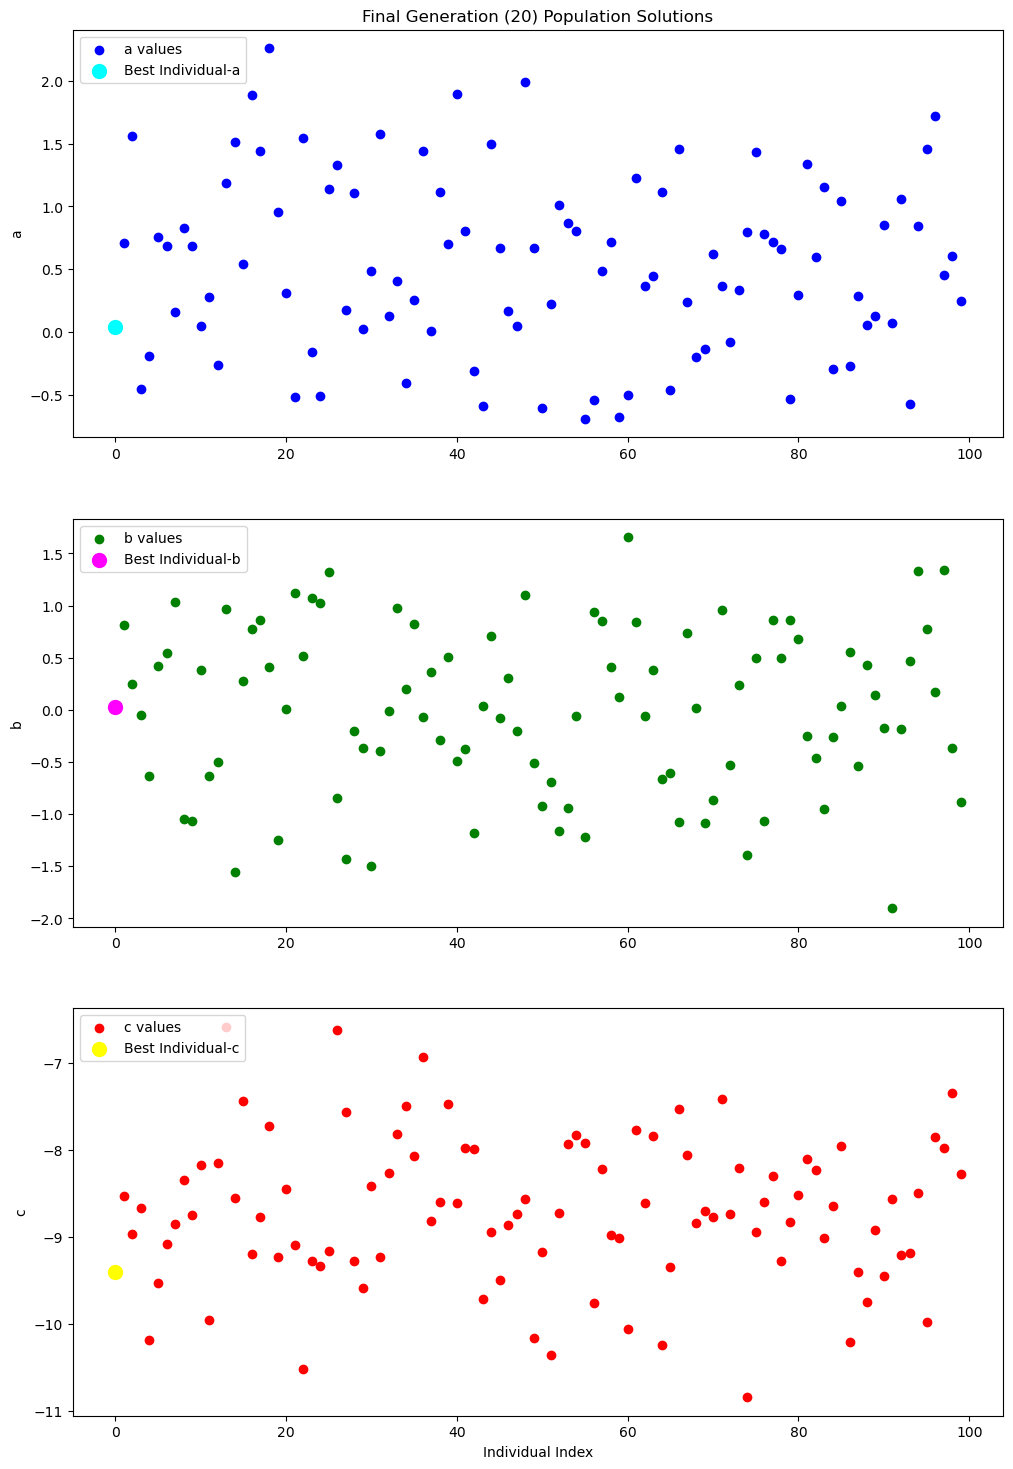

In [14]:
display(figs[0])

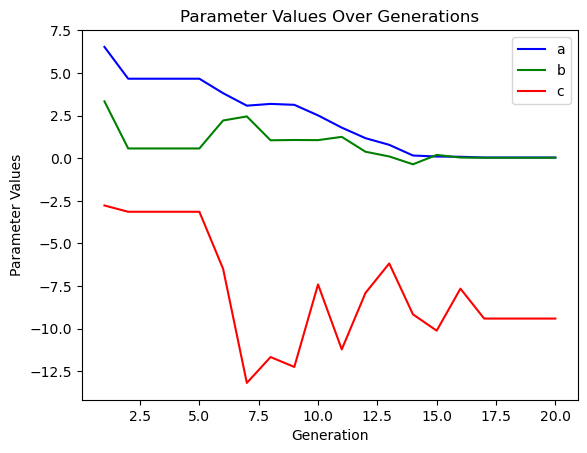

In [15]:
display(figs[1])

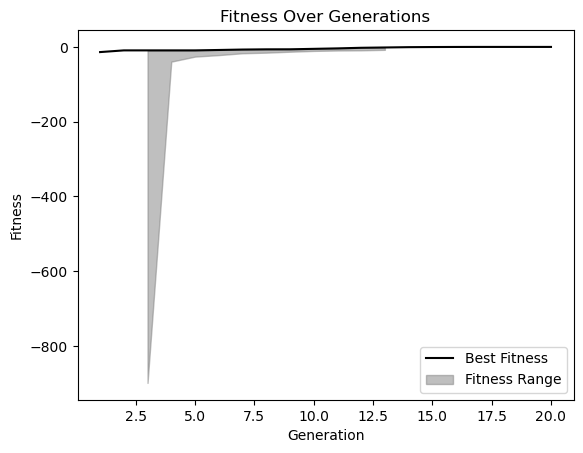

In [16]:
display(figs[2])

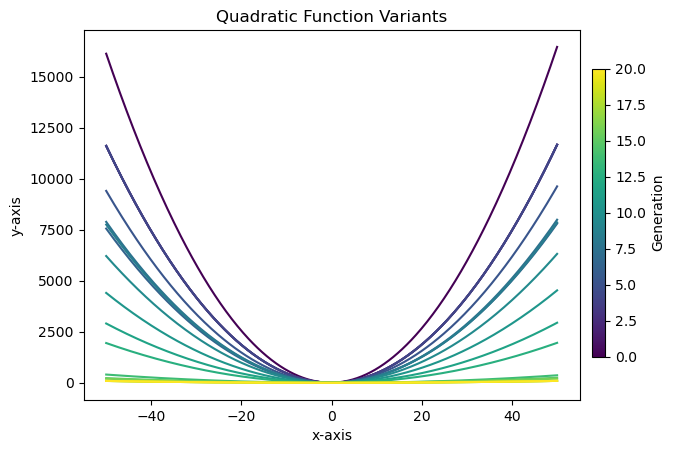

In [17]:
display(figs[3])

# Final Solution

In [19]:
print(f"Best solution found: a = {best_solution[0]}, b = {best_solution[1]}, c = {best_solution[2]}")

Best solution found: a = 0.03799060222169748, b = 0.024337673820480243, c = -9.401875911028647
